# Método das Características - Onda de Cheia

## Problema:

Desenvolver uma rotina computacional para a determinação da:
 - velocidade média $V$ e;
 - da profundidade $y$ de escoamento em um canal prismático;
 - para os primeiros 70 minutos resultantes de uma cheia,
ocasionando escoamento superficial não permanente e variado. 
 - O canal retangular tem:
  - largura de topo $B = 20 m$; 
  - comprimento $L = 10.000 m$; 
  - declividade de fundo $I_0 = 0,0016 m/m$; 
  - coeficiente de rugosidade de Chézy $C = 100$; 
  - e não possui contribuição lateral ($q_l = 0$).
  - A montante do canal, a vazão é fornecida pelo hidrograma da Tabela 1. 
  

<center> <b>Tabela 1</b> </center>

 Tempo(min) | Vazão (m³/s)
--- | ---
0|560
5|730
10|1020
15|1220
20|930
25|730
30|600
35|510
40|455
45|410
50|410
55|410
60|410
65|410
70|410


 - Ao final dos $10.000 m$ 
 - existe uma régua que relaciona a profundidade do canal à vazão (curva-chave), cuja equação é $Q = 111,7118*(y – 0,3848)^{1,2277}$.
 - Utilizar o Método das Características para os cálculos de $V$ e $y$;
 - e a equação de Chézy para o cálculo de $I_f$.
 - Fórmula de Chézy: $Q = C*A*(R_h.I_f)^{0,5}$;
  - sendo $Q$ a vazão;
  - $C$ o coeficiente de rugosidade; 
  - $A$ a área da seção transversal; 
  - $R_h$ o raio hidráulico;
  - $I_f$ a declividade da linha de energia.

# Código e Resultados

In [1]:
#Importação das bibliotecas a serem usadas
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from sys import exit

In [2]:
#Valores Iniciais
B = 20 #Largura do Canal
L = 10000 #Comprimento do canal
I0 = 0.0016 #Declividade de fundo
C = 100 #Coeficiente de Chezy
g = 9.81 #gravidade
tt = 4200 #70 minutos em segundos

Hidrograma = {"T(s))": [0,300,600,900,1200,1500,1800,2100,2400,2700,3000,3300,3600,3900,4200],
              "Qe": [560,730,1020,1220,930,730,600,510,455,410,410,410,410,410,410]}

#Altura inicial (considerando o escoamento no instante t=0 como permanente e uniforme, 
#podemos obter a altura no canal pela curva chave de jusante)
Q0 = 560
Y0 = (Q0/111.7118)**(1/1.2277)+0.3848

#Velocidade inicial
A0 = B*Y0
V0 = Q0/A0

#condição inicial de Courant dx/dt >= (|v|+c)
c0 = np.sqrt(g*Y0)


dt= 1 #em segundos
#print(dt<=dx/(abs(Vm)+Cm))
dx = 20 #metros

Nx = int(L/dx)
Nt = int(tt/dt)
print("dt: ", dt)
print("dx: ", dx)
print("Nt:",Nt)
print("Nx: ", Nx)

dt:  1
dx:  20
Nt: 4200
Nx:  500


Para conseguir a discretização maior do tempo, faz-se necessária a interpolação dos dados do hidrograma de entrada

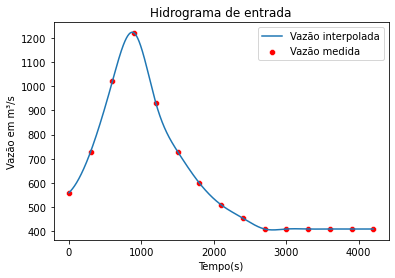

In [3]:
tempo = np.arange(0,tt+1)
tempo1 = np.arange(0,tt+dt,dt)
tempomin = tempo1 /60
comprimento = np.arange(0,L+dx,dx)
Qe_int = interp1d(Hidrograma['T(s))'],Hidrograma['Qe'],kind='cubic')
#resultado da interpolação cubica
sns.lineplot(x=tempo, y = Qe_int(tempo))
sns.scatterplot(x=Hidrograma['T(s))'],y=Hidrograma['Qe'], color = 'red', legend=True)
plt.title("Hidrograma de entrada")
plt.ylabel("Vazão em m³/s")
plt.xlabel("Tempo(s)")
plt.legend(labels = ["Vazão interpolada", "Vazão medida"]);

In [4]:
def If(Q,A,C,Rh): #Equação de Chezy para encontrar declividade do nível d'água If
  If = (1/Rh)*(Q/(A*C))**2
  return If

def Q_chave(y): #Equação da curva chave de jusante
  Q = 111.7118*(y-0.3848)**1.2277
  return Q 

## Para montante:
Foi utilizada a vazão interpolada do hidrograma com a característica negativa.

Assim, foi feito a substituição de  $V_{p}=\frac{Q_{p}}{B*y_{p}}$ na característica negativa que, sendo desenvolvida, chega na equação:

$a*y_{p}^{2} + b*y_{p}+c = 0$, onde

$a = -\frac{g}{C_{m}}$

$b = (g(If_{m} - I_{0})\Delta t + \frac{g}{C_{m}}*y_{s}-V_{s}) $

$c = \frac{Q_{p}}{B} $

Por bhaskara, chega-se nas raízes da função e descarta-se a raíz negativa, por ser um valor físicamente impossível e utiliza-se o valor positivo na primeira equação para encontrar $V_{p}$.

## Para os pontos interiores:

Foram utilizadas as equações

$y_{p} = \frac{1}{2}*((V_{R}-V_{S})*\frac{C_{m}}{g}+y_{R}+y_{S})$

$V_{p} = V_{R}-\frac{g}{C_{m}}*(y_{p}-y_{R})-g*(If_{m}-I_{0})*\Delta t$

obtidas na manipulação das características positiva e negativa

## Para Jusante:

Foi utilizado a equação da curva chave com a caracterísitca positiva. Fazendo-se  $V_{p}=\frac{Q_{p}}{B*y_{p}}$, esse valor foi substituido na característica positiva e chegou-se na equação:


$\frac{Q_{p}}{B*y_{p}} -V_{R} + \frac{g}{C_{m}}*(y_{p}-y_{R})+g*(If_{m}-I_{0})*\Delta t = 0 $, onde

$Q_{p} = 111,7118*(y_{p} – 0,3848)^{1,2277}$

O valor de $y_{p}$ foi encontrado por meio do método iterativo `fsolve` do módulo `optimize` da biblioteca `scipy`

In [5]:
#Criando Matrizes de Dados com os valores iniciais (No instante t=0, escoamento é permanente e uniforme, então todos os pontos nesse instante tem altura e velocidade iguais (Y0 e V0, respectivamente))
V = np.ones((Nt+1,Nx+1))*V0
Y = np.ones((Nt+1, Nx+1))*Y0
Q = np.ones((Nt+1, Nx+1))*Q0

# Organizando indices
# A = (t-1, x-1)
# B = (t-1,x+1)
# M = (t-1,x)
# P = (t,x)

t = 1 #começando a partir do intante dt, pois o t=0 já foi feito

for i in range(dt,tt+dt,dt):
  x=0
  #----------CONDIÇÃO DE MONTANTE
  #Dados do Ponto M
  Ym = Y[t-1,x]
  Vm = V[t-1,x]
  Cm = np.sqrt(g*Ym)
  Am = B*Ym
  Pm = B + 2*Ym
  Rh = Am/Pm
  Qm = Q[t-1,x]
  Ifm = If(Qm,Am,C,Rh)

  if dt <=dx/(abs(Vm)+Cm): #Conferindo se atende a condição de Courant
    #Característica negativa
    if Vm > Cm:
      Vs = Vm + (V[t-1,x-1]-Vm)*(dt/dx)*(Vm-Cm)
      Ys = Ym + (Y[t-1,x-1]-Ym)*(dt/dx)*(Vm-Cm)
    else:
      Vs = Vm + (Vm-V[t-1,x+1])*(dt/dx)*(Vm-Cm)
      Ys = Ym + (Ym-Y[t-1,x+1])*(dt/dx)*(Vm-Cm)
    Qp = Qe_int(i)

    
    a = -g/Cm
    b=(g*(Ifm-I0)*dt+((g/Cm)*Ys)-Vs)
    c=Qp/B
    
    #Para encontrar as raízes da equação a*yp² + b*yp + c = 0, foi utilizado o método np.roots da biblioteca numpy

    Yp = np.roots([a,b,c])
    Y[t,x] = Yp.max()
    Q[t,x] = Qp
    V[t,x] = Qp/(B*Y[t,x])
  else:
    exit("Ajuste o seu passo de tempo (dt) ou seu passo espacial (dx) para atender a condição de courant: dt <=dx/(|Vm|+Cm) ")

  #-----------------PONTOS INTERNOS
  x = 1
  for j in range(dx,L,dx):
    
    Ym = Y[t-1,x]
    Vm = V[t-1,x]
    Cm = np.sqrt(g*Ym)
    Am = B*Ym
    Pm = B + 2*Ym
    Rh = Am/Pm
    Qm = Vm*Am
    Ifm = If(Qm,Am,C,Rh)

    if dt <=dx/(abs(Vm)+Cm):#Conferindo se atende a condição de Courant
      #Característica Positiva
      Vr = Vm + (V[t-1, x-1]-Vm)*(dt/dx)*(Vm+Cm)
      Yr = Ym + (Y[t-1, x-1]-Ym)*(dt/dx)*(Vm+Cm)

      #Característica Negativa
      if Vm > Cm:
        Vs = Vm + (V[t-1,x-1]-Vm)*(dt/dx)*(Vm-Cm)
        Ys = Ym + (Y[t-1,x-1]-Ym)*(dt/dx)*(Vm-Cm)
      else:
        Vs = Vm + (Vm-V[t-1,x+1])*(dt/dx)*(Vm-Cm)
        Ys = Ym + (Ym-Y[t-1,x+1])*(dt/dx)*(Vm-Cm)
      
      Y[t,x] = 0.5*((Vr-Vs)*(Cm/g)+Yr+Ys)
      V[t,x] = Vr - (g/Cm)*(Y[t,x]-Yr)-g*(Ifm-I0)*dt
      Q[t,x] = V[t,x]*(B*Y[t,x])
    # print((t,x), (Y[t,x],V[t,x]))
    else:
      exit("Ajuste o seu passo de tempo (dt) ou seu passo espacial (dx) para atender a condição de courant: dt <=dx/(|Vm|+Cm) ")

    x+=1
  #---------Condições de jusante

  x=Nx  
  Ym = Y[t-1,x]
  Vm = V[t-1,x]
  Cm = np.sqrt(g*Ym)
  Am = B*Ym
  Pm = B + 2*Ym
  Rh = Am/Pm
  Qm = Vm*Am
  Ifm = If(Qm,Am,C,Rh)
   
  if dt <=dx/(abs(Vm)+Cm):#Conferindo se atende a condição de Courant
    #Característica Positiva
    Vr = Vm + (V[t-1, x-1]-Vm)*(dt/dx)*(Vm+Cm)
    Yr = Ym + (Y[t-1, x-1]-Ym)*(dt/dx)*(Vm+Cm)

    def eq(Yp):
      res = (111.7118*(Yp-0.3848)**1.2277)/(B*Yp) - Vr +(g/Cm)*(Yp-Yr) + g*(Ifm-I0)*dt
      return res
    Yp0 = Ym
    Yp = fsolve(eq,Yp0)
    Y[t,x] = Yp
    V[t,x] = Q_chave(Yp)/(B*Yp)
    Q[t,x] = Q_chave(Yp)
    #print(dt<=dx/(abs(Vm)+Cm))
  else:
    exit("Ajuste o seu passo de tempo (dt) ou seu passo espacial (dx) para atender a condição de courant: dt <=dx/(|Vm|+Cm) ")
  t+=1

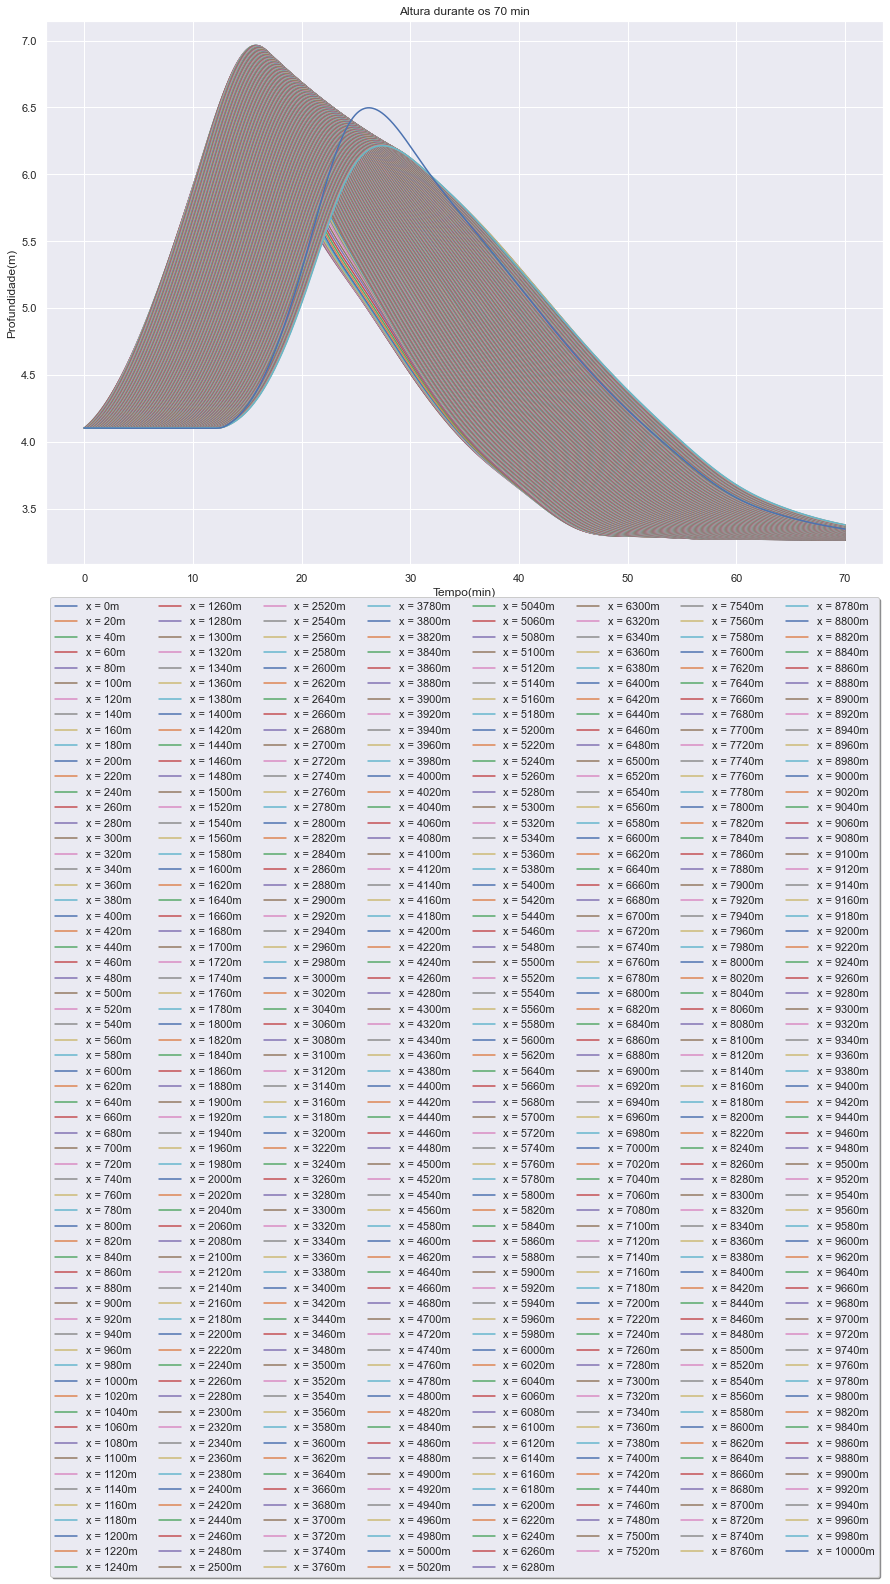

In [6]:
sns.set_theme()
plt.figure(figsize=(15,10))
plt.title("Altura durante os 70 min")
plt.ylabel("Profundidade(m)")
plt.xlabel("Tempo(min)")
label = []
for i in range(0,Nx+1):
    sns.lineplot(x = tempomin, y = Y[:,i])
    label.append(f"x = {i*dx}m")
plt.legend(labels = label, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=8);


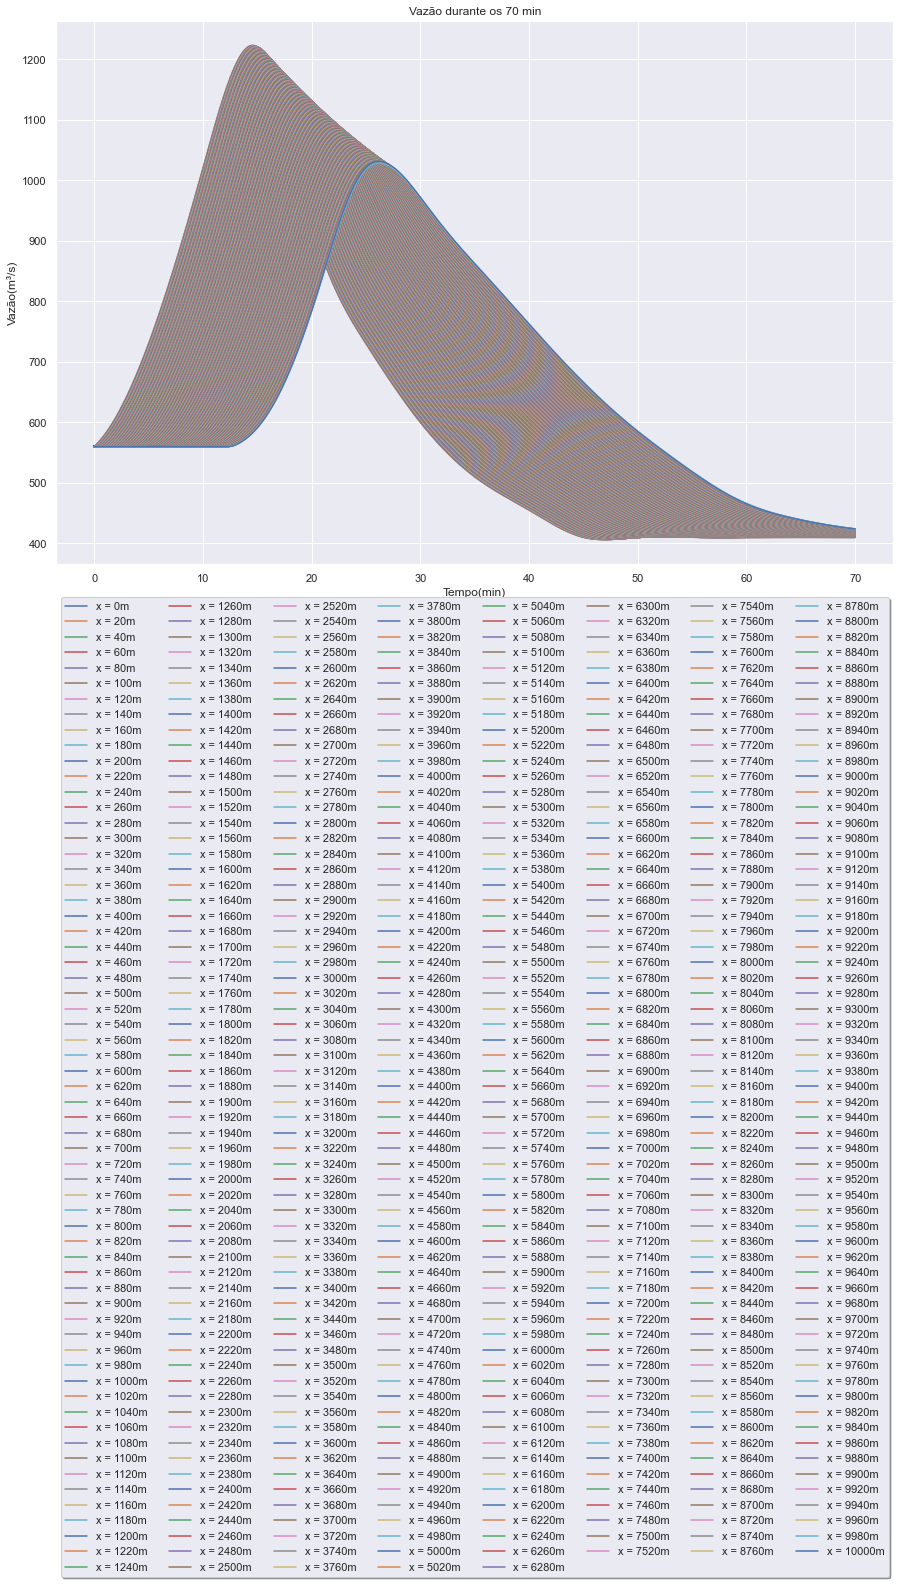

In [7]:
plt.figure(figsize=(15,10))
plt.title("Vazão durante os 70 min")
plt.ylabel("Vazão(m³/s)")
plt.xlabel("Tempo(min)")
label = []
for i in range(0,Nx+1):
    sns.lineplot(x = tempomin, y = Q[:,i])
    label.append(f"x = {i*dx}m")
plt.legend(labels = label, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=8);


Para a visualização da profundidade do nível d'água no canal, foi feita uma animação por meio do código a seguir:

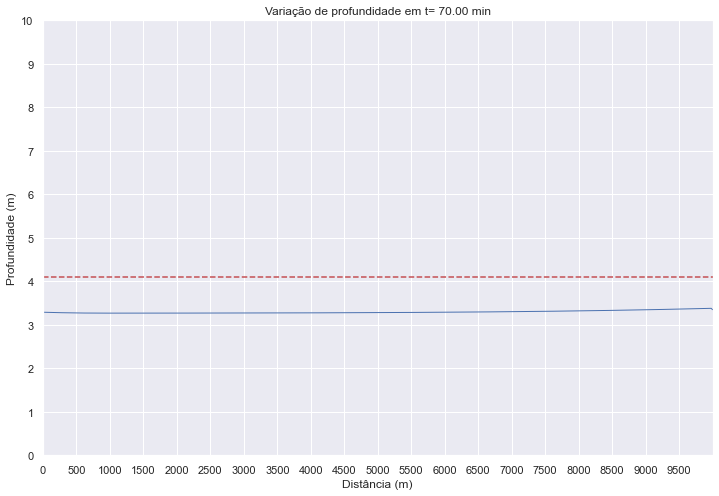

In [9]:
import matplotlib
# matplotlib.use("Agg")
import matplotlib.animation as animation

# Settings
video_file = "Variação da altura numa onda de cheia.mp4"
clear_frames = True     # Should it clear the figure between each frame?
fps = 60

# Output video writer
FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=fps, metadata=metadata)


fig = plt.figure(figsize=(12,8))
x = comprimento
t=0
y=[]
with writer.saving(fig, video_file, 100):
    for i in tempo:
        y.append(Y[t,:])
        
        if clear_frames:
            fig.clear()
        plt.title(f"Variação de profundidade em t= {i/60:.{2}f} min")
        plt.ylabel("Profundidade (m)")
        plt.xlabel("Distância (m)")
        plt.axhline(y=Y0, color='r', linestyle='--')
        plt.yticks(range(0,11))
        plt.xticks(range(0,10000,500))
        plt.ylim((0,10))
        plt.xlim((0,10000))
        ax, = plt.plot(x, y[t], 'b-', linestyle="solid", linewidth=1)
  
        writer.grab_frame()
        t+=1